In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import feature_engineering
import quadratic_weighted_kappa
import qw_kappa_for_tensorflow

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras import regularizers

%reload_ext autoreload
%autoreload 2

### Preparing the data

In [2]:
data = pd.read_csv('data_minus_images/train.csv')

In [3]:
pet_df = feature_engineering.add_everything(data)

In [4]:
pet_df.head()

,PetID,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,score,language,BreedName,BreedGroup,BreedGroupID,purebred,desc_len,start_cap,num_colors,has_name
0,86e1089a3,2,Nibble,3,299,0,1,1,7,0,...,0.3,en,Tabby,CAT,-1,1,359,1,2,1
1,1bf1f95ef,2,Mimi,12,299,0,2,3,6,7,...,0.0,None,Tabby,CAT,-1,1,40,1,3,1
2,987baa1c7,2,Tabby Male,48,299,0,1,1,2,7,...,0.3,en,Tabby,CAT,-1,1,707,1,3,1
3,5c546c236,2,Manja,4,299,0,2,1,2,0,...,0.4,en,Tabby,CAT,-1,1,130,1,2,1
4,c2346525a,2,Cham,8,299,0,1,3,0,0,...,0.5,en,Tabby,CAT,-1,1,99,1,1,1


In [5]:
X = pet_df.drop(columns=['Name','RescuerID','Description','PetID','AdoptionSpeed', 'BreedName', 'BreedGroupID'])
y = pet_df['AdoptionSpeed'].astype('str')

In [6]:
cat_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'language', 'BreedGroup']

In [7]:
for feat in cat_features:
    dummies = pd.get_dummies(X[feat], prefix=feat)
    dummies.drop(dummies.columns[-1], axis=1, inplace=True)
    X = X.drop(feat, axis=1).merge(dummies, left_index=True, right_index=True)

### Continuous, with ReLU and dropouts

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
nn = Sequential()

# input layer
nn.add(Dense(370, activation='relu', input_dim=(X_train.shape[1])))

# hidden lyaers
nn.add(Dropout(0.5))
nn.add(Dense(256, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(64, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(4, activation='relu'))

# output layer
nn.add(Dense(1,activation='linear'))

nn.compile(loss='mae', optimizer=keras.optimizers.Adam(), metrics=['mae'])

trained = nn.fit(X_train, y_train, batch_size=64,epochs=50,verbose=1,validation_data=(X_test, y_test))

Train on 11990 samples, validate on 2998 samples
Epoch 1/50
11990/11990 [==============================] - 2s 207us/step - loss: 4.6068 - mean_absolute_error: 4.6068 - val_loss: 2.3303 - val_mean_absolute_error: 2.3303
Epoch 2/50
11990/11990 [==============================] - 1s 124us/step - loss: 2.2278 - mean_absolute_error: 2.2278 - val_loss: 2.0155 - val_mean_absolute_error: 2.0155
Epoch 3/50
11990/11990 [==============================] - 2s 155us/step - loss: 1.8138 - mean_absolute_error: 1.8138 - val_loss: 1.5485 - val_mean_absolute_error: 1.5485
Epoch 4/50
11990/11990 [==============================] - 2s 152us/step - loss: 1.5019 - mean_absolute_error: 1.5019 - val_loss: 1.3802 - val_mean_absolute_error: 1.3802
Epoch 5/50
11990/11990 [==============================] - 2s 136us/step - loss: 1.3080 - mean_absolute_error: 1.3080 - val_loss: 1.1948 - val_mean_absolute_error: 1.1948
Epoch 6/50
11990/11990 [==============================] - 2s 136us/step - loss: 1.1803 - mean_absolut

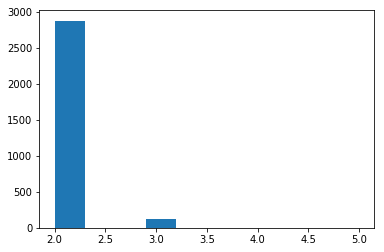

In [10]:
y_predict = nn.predict(X_test)
y_predict = y_predict.reshape((1,-1))
y_predict = y_predict.round()[0]
plt.hist(y_predict)
plt.show()

In [11]:
quadratic_weighted_kappa.quadratic_weighted_kappa(y_predict, y_test)

0.018645559686559232

Note Alex re-binned the predictions rather than rounding and got a better score.

### Categorical, with SELU activation and regularization

In [12]:
y_one = pd.get_dummies(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one, test_size=0.20, random_state=42)

In [14]:
y_test_class = y_test.idxmax(axis=1)

In [38]:
nn = Sequential()
nn.add(Dense(256, activation='selu', input_dim=(X_train.shape[1]),
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
nn.add(Dense(64, activation='selu',
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
nn.add(Dense(32, activation='selu'))
nn.add(BatchNormalization())
nn.add(Dropout(0.5))
nn.add(Dense(5,activation='sigmoid'))

In [39]:
nn.compile(loss=qw_kappa_for_tensorflow.kappa_loss, optimizer=keras.optimizers.Adam(), metrics=['mae'])

trained = nn.fit(X_train, y_train, batch_size=32, epochs=40, verbose=1, validation_data=(X_test, y_test))

#nn.evaluate(X_test, y_test)

Train on 11990 samples, validate on 2998 samples
Epoch 1/40
11990/11990 [==============================] - 3s 254us/step - loss: 132.5148 - mean_absolute_error: 0.4755 - val_loss: 28.6247 - val_mean_absolute_error: 0.4448
Epoch 2/40
11990/11990 [==============================] - 2s 156us/step - loss: 22.6699 - mean_absolute_error: 0.4320 - val_loss: 20.1719 - val_mean_absolute_error: 0.3707
Epoch 3/40
11990/11990 [==============================] - 2s 154us/step - loss: 18.6565 - mean_absolute_error: 0.3909 - val_loss: 22.5509 - val_mean_absolute_error: 0.3846
Epoch 4/40
11990/11990 [==============================] - 2s 191us/step - loss: 17.4490 - mean_absolute_error: 0.3432 - val_loss: 16.2696 - val_mean_absolute_error: 0.2960
Epoch 5/40
11990/11990 [==============================] - 2s 180us/step - loss: 17.5081 - mean_absolute_error: 0.2864 - val_loss: 18.2946 - val_mean_absolute_error: 0.3261
Epoch 6/40
11990/11990 [==============================] - 2s 183us/step - loss: 18.9603 - 

In [40]:
y_predict = nn.predict_classes(X_test)
#y_predict = y_predict.reshape((1,-1))
#y_predict = y_predict.round()[0]

In [41]:
y_predict

array([1, 1, 1, ..., 1, 4, 1])

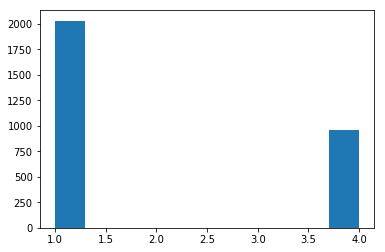

In [42]:
plt.hist(y_predict)
plt.show()

In [37]:
quadratic_weighted_kappa.quadratic_weighted_kappa(y_predict, y_test_class)

0.14258772229825345

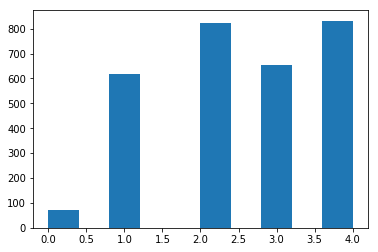

In [311]:
plt.hist(y_test_class.astype('int'))
plt.show()

### Continuous, tanh activation function

In [147]:
model = Sequential()
model.add(Dense(25, activation = 'tanh', input_dim=(X_train.shape[1])))
model.add(Dropout(0.5))
model.add(Dense(40, activation = 'tanh'))
model.add(Dense(units=1, activation = 'linear'))
model.compile(loss='mae', optimizer='Adam', metrics=['mae'])
model.fit(X_train, y_train, batch_size=64,epochs=30,verbose=0,validation_data=(X_test, y_test))

In [148]:
y_predict = model.predict(X_test)
y_predict = y_predict.reshape((1,-1))
y_predict = y_predict.round()[0]

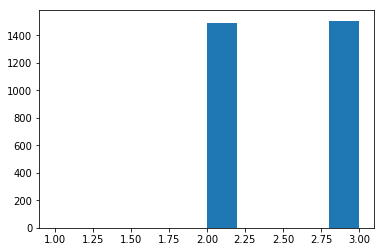

In [149]:
plt.hist(y_predict)
plt.show()

In [150]:
quadratic_weighted_kappa.quadratic_weighted_kappa(y_predict, y_test)

0.19797645910988892